In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

# 0. Plan działania

Każdy projekt związany z uczeniem maszynowym jest inny, można jednak wyróżnić pewne kroki które zawsze muszą być wykonane:
- Zdobycie zbioru danych
- Zapoznanie się ze zbiorem danych (EDA)
- Przygotowanie danych do analizy (preprocessing)
- Wytrenowanie modelu
- Ewaluacja modelu

Na tych zajęciach przejdziemy przez te kroki dla problemu regresji: przewidzenie ceny domu w Bostonie. 

# 1. Importowanie zbioru danych

In [2]:
boston_dict = load_boston()
print(boston_dict.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [3]:
print(boston_dict.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


Widzimy, że otrzymany zbiór danych jest typu `dict`. Sprawdzimy teraz, co znajduje się w tym słowniku i w jaki sposób surowe dane możmy zamienić na obiekt typu `pd.DataFrame` w celu łatwej pracy z nim.

In [4]:
# W tej komórce przejrzyj co znajduje się pod interesującymi Cię kluczami w słowniku
# Pod którym kluczem znajduje się X? Pod którym y?



Wskazówka do komórki poniżej: użyj funkcji `print()`.

In [5]:
# W tej komórce wyświetl opis danych 



Teraz wczytamy wszystkie nasze dane (zarówno $X$ jak i $y$) do obiektu typu `pd.DataFrame`.

In [6]:
boston_df = pd.DataFrame(boston_dict['data'], columns=boston_dict['feature_names'])
boston_df['MEDV'] = boston_dict['target']

# 2. Eksploracyjna analiza danych

W tym momencie wszystkie nasze dane są przechowywane w ramce danych `boston_df`. Użyjemy teraz kolejno metod obiektów `pd.dataframe`: `.head()`, `.info()`, `.describe()` oraz `.hist()` w celu lepszego zapoznania się z danymi. 


In [7]:
# Wywołaj metodę head() na obiekcie boston_df 



In [8]:
# Wywołaj metodę info() na obiekcie boston_df 



In [9]:
# Wywołaj metodę describe() na obiekcie boston_df 



In [10]:
# Wywołaj metodę hist() na obiekcie boston_df 
# Poeksperymentuj z parametrami -- dobrym rozwiązaniem wydają się być wartości (bins = 40, figsize=(18, 12))
# Kod powinien się znajdować powyżej linijki plt.show()


plt.show()

Ponieważ nasz model będzie modelem regresji liniowej, wartościowe może się okazać przyjrzenie się zależności pomiędzy zmiennymi modelu a zmienną celu. 

Znacie jakiś bardziej elegancki sposób na uzyskanie tego typu wykresów? 

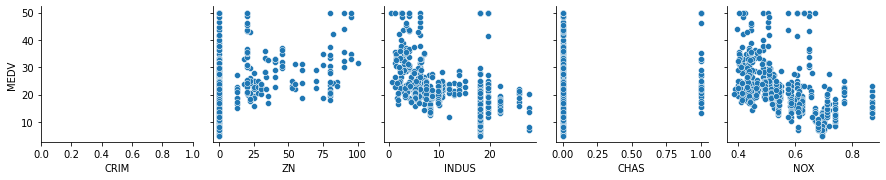

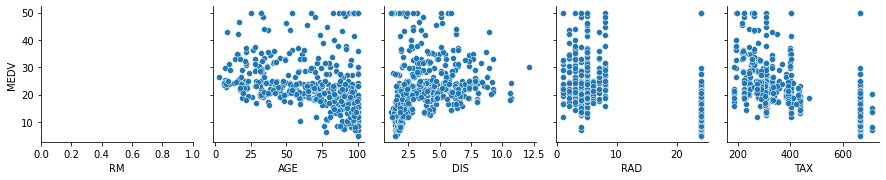

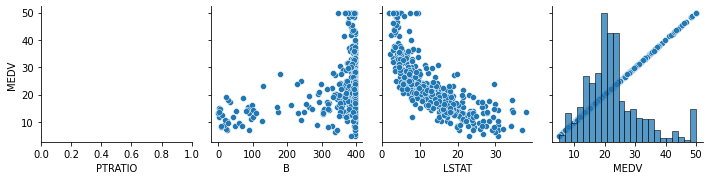

In [11]:
sns.pairplot(boston_df, y_vars="MEDV", x_vars=boston_df.columns.values[:5])
sns.pairplot(boston_df, y_vars="MEDV", x_vars=boston_df.columns.values[5:10])
sns.pairplot(boston_df, y_vars="MEDV", x_vars=boston_df.columns.values[10:])

plt.show()

# 3. Przygotowanie zbioru treningowego oraz testowego

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    boston_df[boston_df.columns.values[:-1]], 
    boston_df[boston_df.columns.values[-1]], 
    test_size=0.33, random_state=42)

# 4. Preprocessing danych

## 4.1. Po co nam preprocessing danych? 

In [13]:
def plot_linear_model(x, y):
    m = LinearRegression()
    m.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
    y_hat = m.predict(x.values.reshape(-1, 1))
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y)
    plt.plot(x, y_hat, c='red')
    plt.show()
    plt.close('all')
    print(f'RMSE: {np.sqrt(mean_squared_error(y, y_hat)):.3f}')

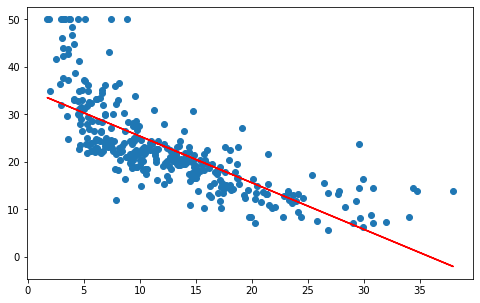

RMSE: 6.222


In [14]:
plot_linear_model(X_train['LSTAT'], y_train)

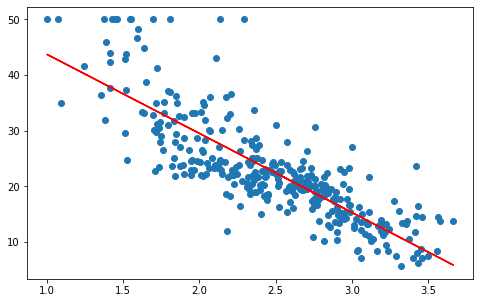

RMSE: 5.307


In [15]:
plot_linear_model(np.log1p(X_train['LSTAT']), y_train)

## 4.2. Właściwy preprocessing danych

Dzięki wywołanej wcześniej metodzie `.info()` wiemy, że w naszym zbiorze danych nie ma braków danych (`506 non-null`). Jedyny preprocessing jaki chcemy wykonać, to transformacja danych.

In [16]:
log_features = ['LSTAT', 'CRIM', 'INDUS', 'NOX']


transformer = ColumnTransformer(
    [
        ('log', FunctionTransformer(np.log1p), log_features)
    ],
    remainder = 'passthrough'
)

# 5. Przygotowanie modelu

## Model liniowy

Wytrenujemy teraz najprostszy model stosowany w problemach regresji: model liniowy. Zostanie on dokładniej omówiony na dalszych zajęciach. Do oceny modelu wykorzystamy miarę **RMSE**. Jest ona zdefiniowana w następujący sposób:

$$ RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^2} $$

Jest to pierwiastek z uśrednionego kwadratu odległości predykcji $\hat{y}$ od wartości prawdziwej $y$. Im niższa wartość, tym lepiej.


In [17]:
pipe_simple = pipe_transformer = Pipeline(
    [
        ('linear-model', LinearRegression())
    ]
)

pipe_transformer = Pipeline(
    [
        ('transformer', transformer),
        ('linear-model', LinearRegression())
    ]
)


In [18]:
pipe_simple.fit(X_train, y_train)
y_test_hat = pipe_simple.predict(X_test)

print(f'RMSE (bez transformacji danych): {np.sqrt(mean_squared_error(y_test, y_test_hat)):.3f}')

RMSE (bez transformacji danych): 4.552


In [19]:
pipe_transformer.fit(X_train, y_train)
y_test_hat = pipe_transformer.predict(X_test)

print(f'RMSE (z transformacją danych): {np.sqrt(mean_squared_error(y_test, y_test_hat)):.3f}')

RMSE (z transformacją danych): 4.193


Możemy zaobserwować, że transformując część zmiennych udało nam się osiągnąć niższą wartość RMSE. 

## Baseline

Skąd wiemy że nasz model radzi sobie dobrze? Standardową strategią w takiej sytuacji jest wybór baselinu, czyli bardzo prostej metody, którą chcemy "przebić". W naszym przypadku, jako baseline przyjmiemy stałą która minimalizuje RMSE.  

Zadanie: Jaka stała minimalizuje RMSE?

In [20]:
##TODO: obliczenie baselinu dla zbioru i porównanie go z modelem